### Basic Tutorial: Jax Version


The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

In [1]:
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch
import pickle

wandb not available
wandb not available


In [2]:
MODEL = "angle"
RUN_SIMS = False
DEVICE = "cpu"

In [3]:
# MAKE CONFIGS
model = MODEL
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = model
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 256
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 1000
# Specify folder in which to save generated data
generator_config["output_folder"] = "data/lan_mlp/" + model + "/"

# Make model config dict
model_config = ssms.config.model_config[model]

In [4]:
# MAKE DATA
if RUN_SIMS:
    n_datafiles = 10
    for i in range(n_datafiles):
        my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
            generator_config=generator_config, model_config=model_config
        )
        training_data = my_dataset_generator.generate_data_training_uniform(save=True)

In [5]:
from copy import deepcopy

network_config = deepcopy(lanfactory.config.network_configs.network_config_mlp)
network_config["layer_sizes"] = [100, 100, 100, 1]
network_config["activations"] = ["tanh", "tanh", "tanh", "linear"]

print("Network config: ")
print(network_config)

train_config = deepcopy(lanfactory.config.network_configs.train_config_mlp)
train_config["learning_rate"] = 0.000002

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 100, 1], 'activations': ['tanh', 'tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 2e-06, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


In [6]:
network_config

{'layer_sizes': [100, 100, 100, 1],
 'activations': ['tanh', 'tanh', 'tanh', 'linear'],
 'train_output_type': 'logprob'}

In [7]:
train_config["cpu_batch_size"] = 128
train_config["gpu_batch_size"] = 256
train_config["n_epochs"] = 5

In [8]:
train_config

{'cpu_batch_size': 128,
 'gpu_batch_size': 256,
 'n_epochs': 5,
 'optimizer': 'adam',
 'learning_rate': 2e-06,
 'lr_scheduler': 'reduce_on_plateau',
 'lr_scheduler_params': {},
 'weight_decay': 0.0,
 'loss': 'huber',
 'save_history': True}

#### Prepare for Training

Next we set up dataloaders for training with pytorch. The `LANfactory` uses custom dataloaders, taking into account particularities of the expected training data.
Specifically, we expect to receive a bunch of training data files (the present example generates only one), where each file hosts a large number of training examples. 
So we want to define a dataloader which spits out batches from data with a specific training data file, and keeps checking when to load in a new file. 
The way this is implemented here, is via the `DatasetTorch` class in `lanfactory.trainers`, which inherits from `torch.utils.data.Dataset` and prespecifies a `batch_size`. Finally this is supplied to a [`DataLoader`](https://pytorch.org/docs/stable/data.html), for which we keep the `batch_size` argument at 0.

The `DatasetTorch` class is then called as an iterator via the DataLoader and takes care of batching as well as file loading internally. 

You may choose your own way of defining the `DataLoader` classes, downstream you are simply expected to supply one.

In [9]:
folder_ = os.path.join("data", "lan_mlp", MODEL)
file_list_ = [folder_ + '/' + file_ for file_ in os.listdir(folder_)]

# Training dataset
jax_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_training_dataloader = torch.utils.data.DataLoader(
    jax_training_dataset, shuffle=True, batch_size=None, num_workers=1, pin_memory=True
)

# Validation dataset
jax_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_validation_dataloader = torch.utils.data.DataLoader(
    jax_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

#### Define Network

In [10]:
# LOAD NETWORK
jax_net = lanfactory.trainers.MLPJaxFactory(network_config=network_config, train=True)

# Save model config
model_folder = os.path.join("data", "jax_models", MODEL)
os.makedirs(model_folder, exist_ok = True)

pickle.dump(
    network_config,
    open(os.path.join(model_folder,
					  "jax_network_config.pickle"), "wb")
		)

#### Train 

In [11]:
jax_trainer = lanfactory.trainers.ModelTrainerJaxMLP(
    train_config=train_config,
    model=jax_net,
    train_dl=jax_training_dataloader,
    valid_dl=jax_validation_dataloader,
    pin_memory=True,
)

In [12]:
jax_trainer.train_dl.dataset.file_ids

['data/lan_mlp/angle/training_data_fc137e42bc6911eea0236ae25f443f62.pickle',
 'data/lan_mlp/angle/training_data_47aaa024bbf211eea0236ae25f443f62.pickle',
 'data/lan_mlp/angle/training_data_6c3d3918ae0611efaf8d6ae25f443f63.pickle',
 'data/lan_mlp/angle/training_data_fa8a5d4ebbf511eea0236ae25f443f62.pickle',
 'data/lan_mlp/angle/training_data_ecd8a05cbbf511eea0236ae25f443f62.pickle',
 'data/lan_mlp/angle/training_data_53621442bc7911eebbda6ae25f443f62.pickle',
 'data/lan_mlp/angle/training_data_ae628f74ae0511efb3976ae25f443f63.pickle',
 'data/lan_mlp/angle/training_data_bca0114cae0511efa6ba6ae25f443f63.pickle']

In [13]:
train_state = jax_trainer.train_and_evaluate(
    output_folder=model_folder,
    output_file_id=MODEL,
    run_id="jax",
    wandb_on=False,
    wandb_project_id="jax",
    save_data_details=True,
    verbose=-1,
    save_all=True,
)

Found folder:  data
Moving on...
Found folder:  data/jax_models
Moving on...
Found folder:  data/jax_models/angle
Moving on...
Epoch: 0 of 5
wandb not available
wandb not available
Epoch 0/5 time: 10.221325635910034s
wandb not available
wandb not available
Epoch 0/5 time: 9.605355978012085s
Epoch: 0 / 5, test_loss: 0.30221882462501526
Epoch: 1 of 5
wandb not available
wandb not available
Epoch 1/5 time: 10.743075847625732s
wandb not available
wandb not available
Epoch 1/5 time: 8.995309829711914s
Epoch: 1 / 5, test_loss: 0.24911217391490936
Epoch: 2 of 5
wandb not available
wandb not available
Epoch 2/5 time: 11.280319929122925s
wandb not available
wandb not available
Epoch 2/5 time: 9.122586965560913s
Epoch: 2 / 5, test_loss: 0.17990097403526306
Epoch: 3 of 5
wandb not available
wandb not available
Epoch 3/5 time: 10.675911903381348s
wandb not available
wandb not available
Epoch 3/5 time: 8.781609058380127s
Epoch: 3 / 5, test_loss: 0.12020830810070038
Epoch: 4 of 5
wandb not available

#### Check Trained Network

We can now re-instantiate our network from the trained weights and check that the output are reasonable.

In [14]:
# Loaded Net
jax_infer = lanfactory.trainers.MLPJaxFactory(
	            network_config=network_config,
                train=False,
            )

In [15]:
forward_pass, forward_pass_jitted = jax_infer.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state=os.path.join("data", 
					   "jax_models",
					   MODEL,
					   "lan_" + MODEL + "__train_state.jax"),
    add_jitted=True,
)

In [16]:
import jax.numpy as jnp

# Test parameters:
theta = deepcopy(ssms.config.model_config[MODEL]["default_params"])

# Comparison simulator run
sim_out = ssms.basic_simulators.simulator.simulator(
    model=MODEL, theta=theta, n_samples=50000
)

# Make input metric
input_mat = jnp.zeros((2000, len(theta) + 2))
for i in range(len(theta)):
    input_mat = input_mat.at[:, i].set(jnp.ones(2000) * theta[i])

input_mat = input_mat.at[:, len(theta)].set(
    jnp.array(
        np.concatenate(
            [
                np.linspace(5, 0, 1000).astype(np.float32),
                np.linspace(0, 5, 1000).astype(np.float32),
            ]
        )
    )
)
input_mat = input_mat.at[:, len(theta) + 1].set(
    jnp.array(
        np.concatenate([np.repeat(-1.0, 1000), np.repeat(1.0, 1000)]).astype(np.float32)
    )
)

net_out = forward_pass_jitted(input_mat)

(array([1.02608629e-04, 0.00000000e+00, 0.00000000e+00, 1.02608629e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.05217258e-04,
        0.00000000e+00, 0.00000000e+00, 1.02608629e-04, 4.10434517e-04,
        3.07825888e-04, 2.05217258e-04, 5.13043146e-04, 5.13043146e-04,
        4.10434517e-04, 6.15651775e-04, 1.02608629e-03, 1.64173807e-03,
        1.43652081e-03, 1.94956395e-03, 2.77043299e-03, 4.10434517e-03,
        4.41217106e-03, 5.64347461e-03, 5.74608323e-03, 8.61912485e-03,
        1.04660802e-02, 1.12869492e-02, 1.59043375e-02, 1.98034654e-02,
        2.32921588e-02, 3.04747629e-02, 4.17617121e-02, 4.99704024e-02,
        6.27964811e-02, 8.07529912e-02, 1.01069500e-01, 1.26208614e-01,
        1.61403374e-01, 2.03678129e-01, 2.57034616e-01, 3.24961529e-01,
        3.93401484e-01, 4.34650153e-01, 1.68483369e-01, 5.36643131e-02,
        3.95761483e-01, 4.21208423e-01, 3.52050207e-01, 2.81865904e-01,
        2.25431158e-01, 1.78949449e-01, 1.34212087e-01, 1.135877

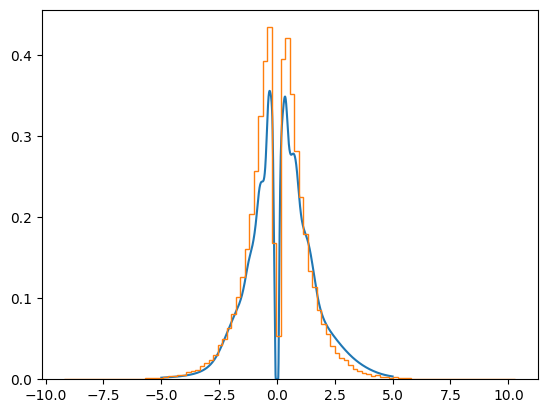

In [17]:
from matplotlib import pyplot as plt

# Plot network log likelihood
plt.plot(np.linspace(-5, 5, 2000).astype(np.float32), np.exp(net_out))

# Plot simulation histogram
plt.hist(
    sim_out["rts"] * sim_out["choices"],
    bins=100,
    histtype="step",
    fill=None,
    density=True,
)